In [1]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [2]:
website_df = pd.read_csv("website_data.csv")
selected_cols = reversed([col for col in website_df.columns if col.startswith("1") or col.startswith("2")])
website_df = website_df[selected_cols]

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_44360/3365711601.py:1: DtypeWarning: Columns (300,304,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  website_df = pd.read_csv("website_data.csv")


In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

for col in tqdm(website_df.select_dtypes(include=['object']).columns):
    website_df[col] = website_df[col].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /Users/vijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 318/318 [00:23<00:00, 13.36it/s]


In [ ]:
import numpy as np
def propagate_str_value_forward(df):
    df = df.copy()
    df.replace('', np.nan, inplace=True)  # Replace empty strings with NaN
    df = df.T.ffill(axis=0).T  # Forward fill NaN values
    df.fillna('', inplace=True)  # Fill remaining NaN with empty strings
    return df
website_df = propagate_str_value_forward(website_df)

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_18665/4171444177.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.T.ffill(axis=0).T  # Forward fill NaN values


In [13]:
import re

session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
normalized_session_scores = []

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    websites_count = subset.count()

    subset = subset.fillna("")
    subset = subset.astype(str)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        pattern = re.escape(phrase)
        phrase_count[phrase] = subset.str.count(pattern, flags=re.IGNORECASE)

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        phrase_count_sum = website_stats.sum()
        if phrase_count_sum == 0:
            continue
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (website_stats[phrase] / phrase_count_sum - alpha)
        year_score += y_n_numerator / y_n_denominator

    normalized_session_scores.append(year_score / websites_count)
    print(f"Year {year} score: {year_score / websites_count}")
    

100%|██████████| 5189/5189 [00:01<00:00, 4528.34it/s]


Year 2007 score: 0.04686104764864288


100%|██████████| 5189/5189 [00:01<00:00, 4525.30it/s]


Year 2008 score: 0.05117600521372998


100%|██████████| 5189/5189 [00:01<00:00, 4544.50it/s]


Year 2009 score: 0.03167038117492163


100%|██████████| 5189/5189 [00:01<00:00, 4380.60it/s]


Year 2010 score: 0.025321035474442026


100%|██████████| 5189/5189 [00:01<00:00, 4268.27it/s]


Year 2011 score: 0.022924491553959165


100%|██████████| 5189/5189 [00:01<00:00, 4687.65it/s]


Year 2012 score: 0.021475161759782087


100%|██████████| 5189/5189 [00:01<00:00, 4449.05it/s]


Year 2013 score: 0.027734338556535284


100%|██████████| 5189/5189 [00:01<00:00, 4459.57it/s]


Year 2014 score: 0.025805452739728216


100%|██████████| 5189/5189 [00:01<00:00, 4281.53it/s]


Year 2015 score: 0.03329616598831347


100%|██████████| 5189/5189 [00:01<00:00, 4335.34it/s]


Year 2016 score: 0.03644734886589205


100%|██████████| 5189/5189 [00:01<00:00, 4310.84it/s]


Year 2017 score: 0.06477625950376927


100%|██████████| 5189/5189 [00:01<00:00, 4345.18it/s]


Year 2018 score: 0.06695519808942724


100%|██████████| 5189/5189 [00:01<00:00, 4293.02it/s]


Year 2019 score: 0.09053136314053398


100%|██████████| 5189/5189 [00:01<00:00, 4088.08it/s]

Year 2020 score: 0.10484557784836673


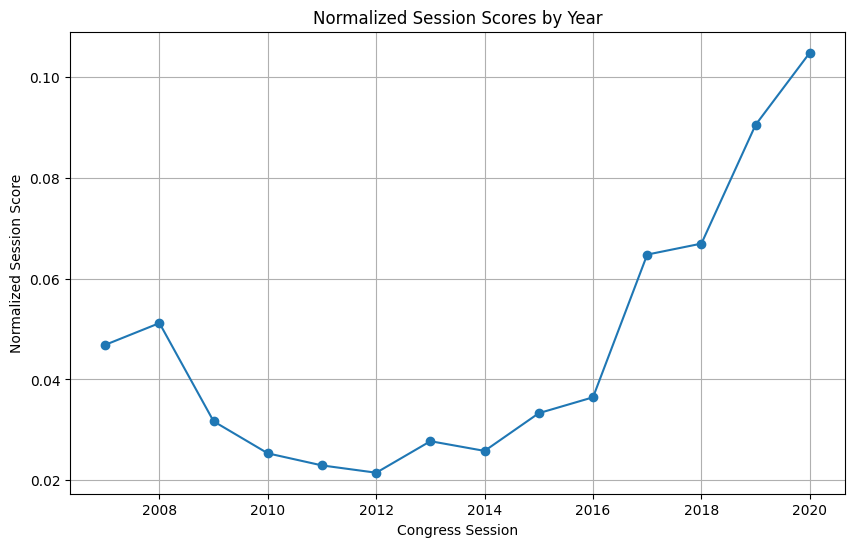

In [16]:
import matplotlib.pyplot as plt

# Plotting the normalized session scores
plt.figure(figsize=(10, 6))
plt.plot(list(session_year_map.keys()), normalized_session_scores, marker='o')
plt.xlabel('Congress Session')
plt.ylabel('Normalized Session Score')
plt.title('Normalized Session Scores by Year')
plt.grid(True)
plt.show()